In [7]:
import requests
import pandas as pd
import datetime
from datetime import datetime

def tick_to_price(tick, decimals0, decimals1):
    return 1.0001 ** - tick * (10 ** (decimals1 - decimals0))

def fetch_uniswap_swaps(pool_address, start_date, end_date, total_nb_swaps, limit=1000):
    endpoint = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
    query = """
    query MyQuery($pool: String!, $first: Int!, $end_date: Int!, $skip: Int!) {
      swaps(
        where: {pool: $pool, transaction_: {timestamp_lte: $end_date}}
        orderBy: timestamp
        orderDirection: desc
        first: $first
        skip: $skip
      ) {
        amount0
        amount1
        amountUSD
        origin
        tick
        sqrtPriceX96
        sender
        recipient
        timestamp
        recipient
        id
        sqrtPriceX96
        tick
        token1 {
          decimals
          symbol
        }
        token0 {
          decimals
          symbol
        }
        transaction {
          gasUsed
          gasPrice
          blockNumber
          timestamp
        }
      }
    }
    """

    swaps = []
    skip = 0

    while len(pd.DataFrame(swaps)) < total_nb_swaps:
    #while swaps == [] or int(pd.DataFrame(swaps).timestamp.iloc[-1]) > start_date:
        variables = {"pool": pool_address, "end_date": end_date, "first": limit, "skip": skip}
        response = requests.post(endpoint, json={'query': query, 'variables': variables})
        try:
            data = response.json()['data']['swaps']
        except:
            pass
        swaps.extend(data)
        skip += limit
        print(datetime.utcfromtimestamp(int(pd.DataFrame(swaps).timestamp.iloc[-1])))
        
    df = pd.DataFrame(swaps)
    
    df[['amount0', 'amount1', 'amountUSD', 'timestamp']] = df[['amount0', 'amount1', 'amountUSD', 'timestamp']].astype('float')
    df[['sender', 'recipient', 'origin']] = df[['sender', 'recipient', 'origin']].astype('str')

    df['gasUsed']  = df['transaction'].apply(lambda x: x['gasUsed']).astype('int')
    #df['gasPrice_gwei'] = df['transaction'].apply(lambda x: x['gasPrice']).astype('int')
    #df['gasPrice_eth'] = df['gasPrice_gwei']*10**-18
    df['gasPrice_wei'] = df['transaction'].apply(lambda x: float(x['gasPrice']))
    df['gasPrice_eth'] = df['gasPrice_wei'] * 10**-18
    
    df['blockNumber'] = df['transaction'].apply(lambda x: x['blockNumber']).astype('int')
    #df['timestamp'] = df['transaction'].apply(lambda x: x['timestamp']).astype('int')
    
    df['symbol0'] = df['token0'].apply(lambda x: x['symbol']).astype('str')
    df['symbol1'] = df['token1'].apply(lambda x: x['symbol']).astype('str')

    df['decimal0'] = df['token0'].apply(lambda x: x['decimals']).astype('int')
    df['decimal1'] = df['token1'].apply(lambda x: x['decimals']).astype('int')

    df['tick']  = df['tick'].astype('int')
    df['price'] = df.apply(lambda row: tick_to_price(row['tick'], row['decimal0'], row['decimal1']), axis=1)

    df['tcost_usd'] = df['gasPrice_eth']*df['price']*df['gasUsed']
    
    df['time'] = pd.to_datetime(df['timestamp'], unit='s')

    df = df.drop(['token1', 'token0', 'tick', 'decimal0', 'decimal1', 'id', 'sqrtPriceX96', 'transaction'], axis=1)
    
    #df = df.set_index('time')
    #path = df.iloc[0].symbol1 + '_' + df.iloc[0].symbol0 + '_pool_swap-' + str(df.index[0].date()) + '_' + str(df.index[-1].date()) + '.pkl'
    earliest_date = df['time'].min().date()
    latest_date = df['time'].max().date()
    path = df.iloc[0]['symbol1'] + '_' + df.iloc[0]['symbol0'] + '_pool_swap-' + str(earliest_date) + '_' + str(latest_date) + '.pkl'
    df.to_pickle(path)
    df.to_pickle(path)

    return df

In [6]:
swaps = []
start_date = 1705795200
i=0
while swaps==[] or int(pd.DataFrame(swaps).timestamp.iloc[-1]) > start_date:
    print(i)
    i+=1
    if i==10:
        break

0
1
2
3
4
5
6
7
8
9


In [13]:
pool_address = "0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640"
end_date = 1706673840#1706745599 #2024-01-31 23:59:59
start_date = 1705795200 #1704067200 #2024-01-01 00:00:00
df = fetch_uniswap_swaps(pool_address, start_date, end_date, total_nb_swaps=8_000)
df

2024-01-31 00:01:11
2024-01-30 20:03:47
2024-01-30 16:10:11
2024-01-30 11:44:35
2024-01-30 06:22:47
2024-01-30 01:58:11
2024-01-30 01:58:11
2024-01-30 01:58:11


,amount0,amount1,amountUSD,origin,sender,recipient,timestamp,gasUsed,gasPrice_wei,gasPrice_eth,blockNumber,symbol0,symbol1,price,tcost_usd,time
0,-267.146425,0.114160,266.950615,0x9df6b79e66df770ae5ed954539989beb4cf64a19,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706674e+09,246108,1.527742e+10,1.527742e-08,19123969,USDC,WETH,2341.424362,8.803510,2024-01-31 04:03:59
1,-337.078601,0.144044,336.831336,0xb3afb6db38a8e72905165c1fbb96772e63560790,0x1111111254eeb25477b68fb85ed929f73a960582,0x139af0e04478c5428ba64e093658d39a5f35de0c,1.706674e+09,725500,1.536742e+10,1.536742e-08,19123969,USDC,WETH,2341.424362,26.104687,2024-01-31 04:03:59
2,59727.548192,-25.500835,59657.333053,0x24488d5f053ab0e21c8add6dc7bf082aaaf5b68e,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x5ab53ee1d50eef2c1dd3d5402789cd27bb52c1bb,1.706674e+09,798880,1.674496e+10,1.674496e-08,19123965,USDC,WETH,2341.424362,31.321736,2024-01-31 04:03:11
3,20.697484,-0.008838,20.674341,0x2182947a9156e0de9639be8ef0a056fa20393d90,0x1111111254eeb25477b68fb85ed929f73a960582,0x1111111254eeb25477b68fb85ed929f73a960582,1.706674e+09,720000,1.747336e+10,1.747336e-08,19123964,USDC,WETH,2340.956147,29.451151,2024-01-31 04:02:59
4,350.000000,-0.149451,349.608912,0xe09ec984d92a086cdc3de3977f9359d3ecfff04b,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706674e+09,278679,1.612233e+10,1.612233e-08,19123963,USDC,WETH,2340.956147,10.517813,2024-01-31 04:02:47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7995,150.000000,-0.064769,150.059448,0x156866504f1a6ada3bbe91a713912880f5b86ac4,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706580e+09,265618,1.831266e+10,1.831266e-08,19116201,USDC,WETH,2314.885012,11.260000,2024-01-30 01:59:11
7996,3624.077318,-1.564857,3625.526624,0x1dd333d27746d2283d01c5a759cb04a0ead821d4,0x00000000ede6d8d217c60f93191c060747324bca,0x00000000ede6d8d217c60f93191c060747324bca,1.706580e+09,2917196,2.786143e+10,2.786143e-08,19116200,USDC,WETH,2314.885012,188.147485,2024-01-30 01:58:59
7997,5980.000000,-2.582179,5982.446120,0xcb2116ceba2019b6fa93b0f05208d297bd2272f5,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0xcc335bb8dc9cabe62bd8e30b6fb461ae2c25b16f,1.706580e+09,300907,1.880583e+10,1.880583e-08,19116197,USDC,WETH,2314.885012,13.099483,2024-01-30 01:58:23
7998,-299.000000,0.129240,299.273659,0xb4868e02b77fc4b315b23fb556c555fa6d50ba0d,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad,1.706580e+09,641134,1.863671e+10,1.863671e-08,19116196,USDC,WETH,2314.885012,27.659707,2024-01-30 01:58:11


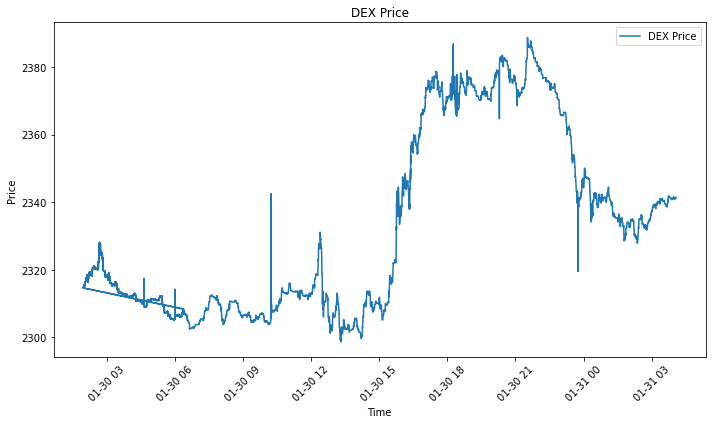

In [14]:
import matplotlib.pyplot as plt 
plt.figure(figsize=(10, 6))

plt.plot(df['time'], df['price'], label='DEX Price')

plt.title('DEX Price')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

/var/folders/fn/zk93lv7x5qb0fyk32l1610240000gn/T/ipykernel_10892/866052578.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  df.groupby('blockNumber').mean().tcost_usd.rolling(50).mean().plot()


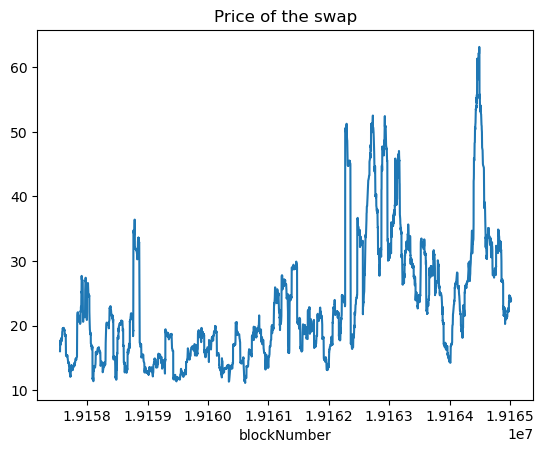

In [41]:
import matplotlib.pyplot as plt 
df.groupby('blockNumber').mean().tcost_usd.rolling(50).mean().plot()
plt.title('Price of the swap')
plt.show()

In [36]:
# those can be considered non arbitrager possibly 
# cause they need to go through the app ui to swap and there is no possibility to select whos the receiver address

print('Percent of pure guys :',round(len(df[df.sender == df.recipient])*100/len(df), 4), '%')

Percent of pure guys : 61.1176 %


In [4]:
print(df.iloc[0].origin)
print(df.iloc[0].sender)

0x8d8ace898ae37e124be2ae7635a476a288bfdc95
0x3fc91a3afd70395cd496c647d5a6cc9d4b2b7fad


In [35]:
print('Percent of unique origines :',round(len(df.origin.unique())*100/len(df), 4), '%')
print('Percent of unique senders  :',round(len(df.sender.unique())*100/len(df), 4), '%')
print('Percent of unique recipient:',round(len(df.recipient.unique())*100/len(df), 4), '%')

Percent of unique origines : 0.7046 %
Percent of unique senders  : 0.0224 %
Percent of unique recipient: 0.208 %


In [26]:
swaps = []
if swaps == []:
    print(1)
else:
    print(2)

1
